In [1]:
#Part 1- Classify all symbols

#Load packages

#%pip install --upgrade pip

%pip install -q numpy emnist pandas matplotlib seaborn scikit-learn tensorflow xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow
import xgboost
import emnist
from IPython.display import display, Markdown


# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28
REBUILD = True

import pkg_resources
installed_packages = pkg_resources.working_set
installed_packages_list = sorted(["%s==%s" % (i.key, i.version) for i in installed_packages])
print(installed_packages_list)


Note: you may need to restart the kernel to use updated packages.


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_16298/1471025653.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


['absl-py==2.1.0', 'annotated-types==0.6.0', 'anyio==4.2.0', 'appnope==0.1.3', 'argon2-cffi-bindings==21.2.0', 'argon2-cffi==23.1.0', 'arrow==1.3.0', 'asttokens==2.4.1', 'astunparse==1.6.3', 'async-lru==2.0.4', 'attrs==23.2.0', 'babel==2.14.0', 'beautifulsoup4==4.12.2', 'bleach==6.1.0', 'cachetools==5.3.2', 'certifi==2023.11.17', 'cffi==1.16.0', 'charset-normalizer==3.3.2', 'comm==0.2.1', 'contourpy==1.2.0', 'cycler==0.12.1', 'dacite==1.8.1', 'debugpy==1.8.0', 'decorator==5.1.1', 'defusedxml==0.7.1', 'emnist==0.0', 'executing==2.0.1', 'fastjsonschema==2.19.1', 'flatbuffers==23.5.26', 'fonttools==4.47.2', 'fqdn==1.5.1', 'gast==0.5.4', 'google-auth-oauthlib==1.2.0', 'google-auth==2.27.0', 'google-pasta==0.2.0', 'grpcio==1.60.1', 'h5py==3.10.0', 'htmlmin==0.1.12', 'idna==3.6', 'imagehash==4.3.1', 'ipykernel==6.28.0', 'ipython-genutils==0.2.0', 'ipython-sql==0.5.0', 'ipython==8.20.0', 'ipywidgets==8.1.1', 'isoduration==20.11.0', 'jedi==0.19.1', 'jinja2==3.1.2', 'joblib==1.3.2', 'json5==0.9

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_16298/1471025653.py:39: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a  BINARY model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)

    # Display metrics for a multi-class model
def display_metrics_multiclass(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(metrics_dict[task][model_name]['confusion_matrix'], index=symbols_list, columns=symbols_list)
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    sns.heatmap(cm_df, annot=True)

        # Display metrics for a multi-class trim
def display_metrics_multiclass_trim(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(metrics_dict[task][model_name]['confusion_matrix'], index=symbols_trim, columns=symbols_trim)
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    sns.heatmap(cm_df, annot=True)





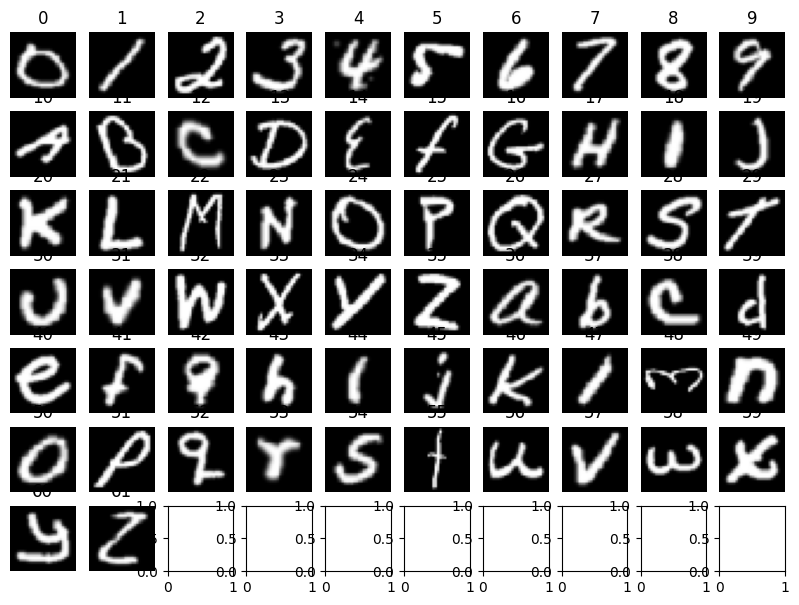

In [3]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
valid = pd.DataFrame()
valid['image'] = list(image)
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
valid['label'] = label
valid['class'] = class_label


# Get the first row for each label
firsts = train.groupby('label').first().reset_index()

# Build a plot with the first image for each label
fig, ax = plt.subplots(7, 10, figsize=(10, 7))
for i in range(62):
    ax[i//10, i%10].imshow(firsts['image'][i], cmap='gray')
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title(firsts['label'][i])

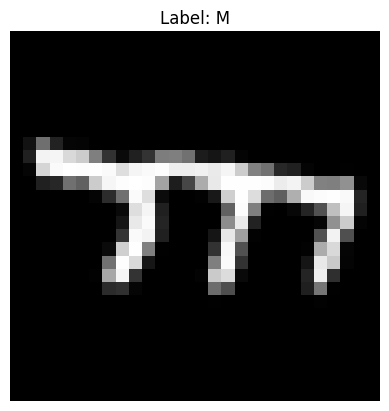

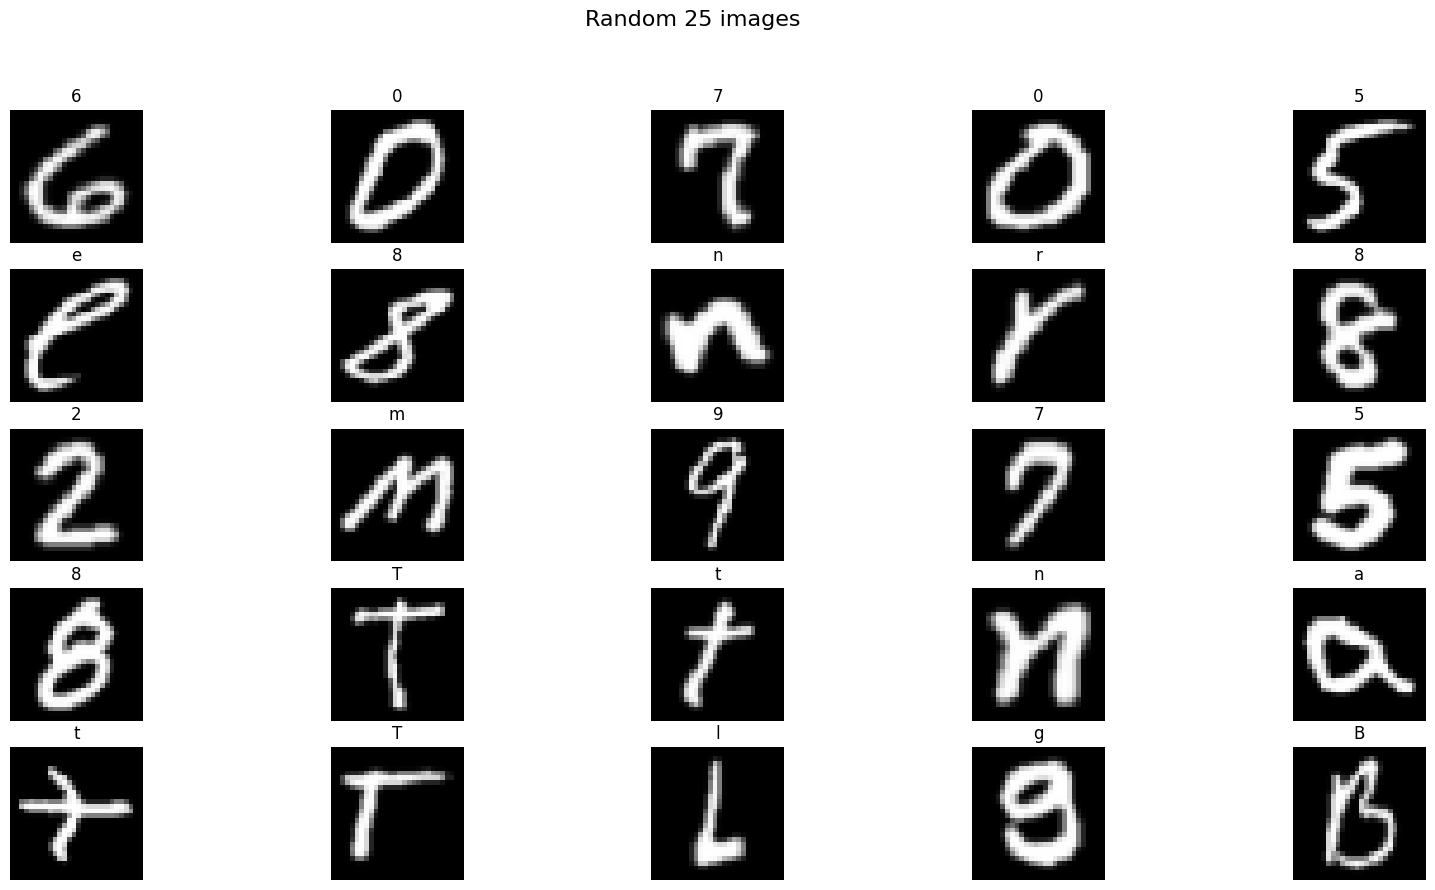

In [4]:
# Using the helper functions

# Plot a random image from the training set
index = np.random.randint(0, len(train))
show_image(train.iloc[index])

# Show a random set of 25 images in a 5x5 grid
show_grid(train.sample(25), title='Random 25 images')

# Show the first 25 images in a 5x5 grid
# show_grid(train[:25], title='First 25 images')

# Isn't it nice to have a helper function to do this for you?

In [5]:
#Quick Descriptive statistics- We had already explored the data in assignment #2, so I did not do a comprehensive exploratory analysis

#Get list of column name
print(train.columns. values. tolist())

#Print first 4 rows
#print(raw_train.head())
display(train.head())

#Identify number of rows and columns
print(train.shape)
print(valid.shape)

#Identify column types
column_types = train.dtypes
print(column_types)

#Assess for missing values in the train/valid set, of which there are none

missing_values = train.isnull().sum()
print(missing_values)

missing_values2 = valid.isnull().sum()
print(missing_values2)


['image', 'image_flat', 'label', 'class']


,image,image_flat,label,class
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,Z
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,6
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,M


(697932, 4)
(116323, 4)
image         object
image_flat    object
label          uint8
class         object
dtype: object
image         0
image_flat    0
label         0
class         0
dtype: int64
image         0
image_flat    0
label         0
class         0
dtype: int64


In [44]:
#Create a symbols list for the subsetted data (a to g)

symbols_short = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

merged_emnist = pd.concat([train, valid], axis=0) #merge together the two datasets, so can split up into different train/test sets
display(merged_emnist)


,image,image_flat,label,class,class_bin
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,Z,letter
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,letter
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,6,digit
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,digit
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,M,letter
...,...,...,...,...,...
116318,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,digit
116319,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",55,t,letter
116320,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,S,letter
116321,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,digit


In [45]:

#Apply the symbols_short dictionary to a new column called class short
#Defined label_short as the integer associated with the class

new_label_short = lambda x: symbols_short.index(x)

merged_emnist['class_short'] = merged_emnist['class'].where(merged_emnist['class'].astype(str).str.contains('|'.join(symbols_short)), None)
merged_emnist_clean = merged_emnist[merged_emnist['class_short'].notnull()]
merged_emnist_clean['label_short'] = merged_emnist_clean['class'].apply(new_label_short)

display(merged_emnist_clean)

mask_clean = merged_emnist_clean['class_short'].apply(lambda x: x in symbols_short) #masking is a method of indexing in pandas
merged_final = merged_emnist_clean[mask_clean]
merged_final.reset_index(drop=True, inplace=True)

display(merged_final)

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_16298/3498362746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_emnist_clean['label_short'] = merged_emnist_clean['class'].apply(new_label_short)


,image,image_flat,label,class,class_bin,class_short,label_short
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,letter,a,0
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,c,letter,c,2
13,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4
24,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4
33,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4
...,...,...,...,...,...,...,...
116290,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,c,letter,c,2
116300,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4
116301,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4
116311,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4


,image,image_flat,label,class,class_bin,class_short,label_short
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,letter,a,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,c,letter,c,2
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4
...,...,...,...,...,...,...,...
68790,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,c,letter,c,2
68791,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4
68792,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4
68793,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,4


In [48]:
# Data splitting- defining X and y
X=merged_final['image_flat'].tolist()
y=merged_final['class_short'].tolist()

In [55]:
 #(OPTIONAL) We can define all the metrics we want to track in a dictionary

metrics_dict = {
    'multi-class classification' : { # multi-class classification. Note we will need multi-class classification for later problems
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [56]:
#Complete code annotation can be found for problem #2 (I did this problem first), code structure is very similar in both problems

import numpy as np
from sklearn.model_selection import ParameterGrid, KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


task = 'multi-class classification'

#Divide data into train, validate, and test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #setting aside 20% of data in test set that will be a hold-out

#within the full training set we will further subdivide into a train and validation set, where the val set will be 25% of the full training set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 


In [57]:
#Random forest nested cross validation for subset a--> g

models = [
    (RandomForestClassifier(), rf_param_grid) #Random forest classifier
]

# Define the parameter grid for hyperparameter tuning
rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}

# Initialize the best score, best model, and best hyperparameters
best_score = -np.inf #Setting to negative infinity will ensure that the best score will be greater than the initialized score
best_inner_score= -np.inf
best_model = None
best_hyperparameters = None

outer_kf = KFold(n_splits=5,shuffle=True, random_state=42) #5 fold cross validation

fold_number = 1  # Initialize fold number.

#We will first consider the outer folds using a for loop
for train_index, test_index in outer_kf.split(X_train):  
    X_train_outer, X_val_outer = [X_train[i] for i in train_index], [X_train[i] for i in test_index]
    y_train_outer, y_val_outer = [y_train[i] for i in train_index], [y_train[i] for i in test_index]

    best_fold_inner_score = -np.inf  # Initialize the best score for this fold

    # Inner cross-validation loop for hyperparameter tuning for each model
    for model, param_grid in models:
        print(f"Model: {model.__class__.__name__}, Fold: {fold_number}")  # Print fold number

        inner_scores = []  # initialize the inner scores

        # Hyper-parameter tuning based on the number of combinations of hyperparameters
        for param_combination in ParameterGrid(param_grid):
            # Initialize and train the model on the training subset
            clf = model.set_params(**param_combination)
            clf.fit(X_train_outer, y_train_outer)

            # Evaluate the model on the validation subset
            y_pred_inner = clf.predict(X_val_outer)  
            inner_score = accuracy_score(y_val_outer, y_pred_inner)
            inner_scores.append(inner_score)  # append all this data into a list for direct comparison

            # Print the results for each combination of hyperparameters for each combination of hyperparameters in each loop
            print(f"Hyperparameters: {param_combination}, Validation Accuracy: {inner_score}")

        # Update the best inner score
        if inner_scores:
            max_inner_score = max(inner_scores)
            if max_inner_score > best_fold_inner_score:
                best_fold_inner_score = max_inner_score
                best_inner_model = model
                best_inner_hyperparameters = param_combination

    # Update the overall best model and hyperparameters to be used in later steps
    if best_fold_inner_score > best_inner_score:
            best_inner_score = best_fold_inner_score
            best_model = best_inner_model
            best_hyperparameters = best_inner_hyperparameters

    fold_number += 1  # Increment fold number



Model: RandomForestClassifier, Fold: 1
Hyperparameters: {'max_depth': None, 'n_estimators': 50}, Validation Accuracy: 0.9562742248062015
Hyperparameters: {'max_depth': None, 'n_estimators': 100}, Validation Accuracy: 0.9548207364341085
Hyperparameters: {'max_depth': None, 'n_estimators': 150}, Validation Accuracy: 0.9568798449612403
Hyperparameters: {'max_depth': 10, 'n_estimators': 50}, Validation Accuracy: 0.9351986434108527
Hyperparameters: {'max_depth': 10, 'n_estimators': 100}, Validation Accuracy: 0.937015503875969
Hyperparameters: {'max_depth': 10, 'n_estimators': 150}, Validation Accuracy: 0.9372577519379846
Hyperparameters: {'max_depth': 20, 'n_estimators': 50}, Validation Accuracy: 0.9548207364341085
Hyperparameters: {'max_depth': 20, 'n_estimators': 100}, Validation Accuracy: 0.9554263565891473
Hyperparameters: {'max_depth': 20, 'n_estimators': 150}, Validation Accuracy: 0.9574854651162791
Model: RandomForestClassifier, Fold: 2
Hyperparameters: {'max_depth': None, 'n_estimat

In [58]:
print("Overall Best Model:", best_model)
print("Overall Best Accuracy:", best_inner_score)  # This represents the best accuracy across all folds
print("Overall Best Hyperparameters:", best_hyperparameters)

Overall Best Model: RandomForestClassifier(max_depth=20, n_estimators=150)
Overall Best Accuracy: 0.959176256814052
Overall Best Hyperparameters: {'max_depth': 20, 'n_estimators': 150}


In [59]:
#Training of model in outer folds using best hyperparameters identified in inner fold training

best_model_outer = best_model.set_params(**best_hyperparameters)
best_model_outer.fit(X_train_outer, y_train_outer)

    # Evaluate the best model using the outer validation subset
y_pred_outer = best_model_outer.predict(X_val_outer)
outer_score = accuracy_score(y_val_outer, y_pred_outer)

    # Update the best score
if outer_score > best_score:
        best_score = outer_score
        best_model = best_inner_model
        best_hyperparameters = best_inner_hyperparameters

# Train the best model on the entire training set (includes training and validation data (80% of total data))
best_model_final = best_model.set_params(**best_hyperparameters)
best_model_final.fit(X_train_val, y_train_val)  

# Calculate predictions on the entire training set
y_pred_train = best_model_final.predict(X_train_val)

# Calculate accuracy on the entire training set
train_accuracy = accuracy_score(y_train_val, y_pred_train)
print("Training Accuracy:", train_accuracy)




Training Accuracy: 0.9975288901809725


In [68]:
# Calculate performance metrics for the best model on the entire training dataset
acc = accuracy_score(y_train_val, y_pred_train)
prec = precision_score(y_train_val, y_pred_train, average='macro')
rec = recall_score(y_train_val, y_pred_train, average='macro')
f1 = f1_score(y_train_val, y_pred_train, average='macro')
#cm = confusion_matrix(y_train_val, y_pred_train)
model_name = best_model_final.__class__.__name__

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1}
                                  #'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: RandomForestClassifier

,accuracy,precision,recall,f1
0,0.997529,0.998509,0.994291,0.996375


# Confusion Matrix: RandomForestClassifier

""


In [69]:
cm = confusion_matrix(y_train_val, y_pred_train)
print("Confusion Matrix for Training Data:")
print(cm)

Confusion Matrix:
[[ 9212     0     3     6     9     0     0]
 [    2  4806     0    10     0     0     0]
 [    0     0  2579     0    73     0     0]
 [    2     0     0  9529     1     0     0]
 [    2     1     2     3 22999     0     0]
 [    0     0     0     4     3  2361     0]
 [    6     1     0     5     3     0  3414]]


In [70]:
# Evaluate the best model on the left out test set
y_pred_test = best_model_final.predict(X_test)
test_score = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_score)

Test Accuracy: 0.963878188821862


In [71]:
task = 'multi-class classification'
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, average='macro')
rec = recall_score(y_test, y_pred_test,average='macro')
f1 = f1_score(y_test, y_pred_test,average='macro')
#cm = confusion_matrix(y_test, y_pred_test)
model_name = best_model_final.__class__.__name__

    # Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                    'precision': prec,
                                    'recall': rec,
                                    'f1': f1}
                                    #'confusion_matrix': cm}
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: RandomForestClassifier

,accuracy,precision,recall,f1
0,0.963878,0.960576,0.932738,0.94562


# Confusion Matrix: RandomForestClassifier

""


In [77]:

cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix for Testing Data:")
print(cm)

Confusion Matrix for Testing Data:
[[2370    4    3   13   39    2   16]
 [   7 1149    3   17    5    7    6]
 [  20    0  531    3   79    0    1]
 [  32   17    2 2267    1    6    3]
 [  26    2   11    7 5662    6    2]
 [   5    3    2    8   11  557    7]
 [  77    3    1   15   19    6  726]]


In [78]:
#Function to identify the labels which have the poorest classification for removal as part of a sensitivity analysis.
#I have decided to threshold at 40 observations, because the model has performed quite well

def find_misclassifications_above_threshold(confusion_matrix, symbols_short, threshold=40):
    misclassifications = []
    for true_label_index in range(len(symbols_short)):
        for predicted_label_index in range(len(symbols_short)):
            if true_label_index != predicted_label_index:
                count = confusion_matrix[true_label_index, predicted_label_index]
                if count > threshold:
                    true_label = symbols_short[true_label_index]
                    predicted_label = symbols_short[predicted_label_index]
                    misclassifications.append((true_label, predicted_label, count))
    return misclassifications

misclassifications = find_misclassifications_above_threshold(cm, symbols_short, threshold=40)

print("Letters with greater than 40 misclassifications:")
for true_label, predicted_label, count in misclassifications:
    print(f"True label '{true_label}' predicted as '{predicted_label}': {count} times")

Letters with greater than 40 misclassifications:
True label 'c' predicted as 'e': 79 times
True label 'g' predicted as 'a': 77 times


In [ ]:
#Poorest performing labels are c, g, e, and a

In [82]:
#Remove c,g,e,a labels as part of a sensitivity analysis

symbols_trim = ['b','d','f','h', 'j', 'k', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

new_label_trim = lambda x: symbols_trim.index(x)

merged_emnist['class_trim'] = merged_emnist['class'].where(merged_emnist['class'].astype(str).str.contains('|'.join(symbols_short)), None)
merged_emnist_clean2 = merged_emnist[merged_emnist['class_trim'].notnull()]
merged_emnist_clean2['label_trim'] = merged_emnist_clean2['class'].apply(new_label_short)

display(merged_emnist_clean2)

mask_clean2 = merged_emnist_clean2['class_trim'].apply(lambda x: x in symbols_short) #masking is a method of indexing in pandas
merged_final2 = merged_emnist_clean2[mask_clean]
merged_final2.reset_index(drop=True, inplace=True)

display(merged_final2)

/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_16298/2023902289.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_emnist_clean2['label_trim'] = merged_emnist_clean2['class'].apply(new_label_short)


,image,image_flat,label,class,class_bin,class_short,class_trim,label_trim
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,letter,a,a,0
5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,c,letter,c,c,2
13,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4
24,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4
33,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4
...,...,...,...,...,...,...,...,...
116290,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,c,letter,c,c,2
116300,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4
116301,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4
116311,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4


,image,image_flat,label,class,class_bin,class_short,class_trim,label_trim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,letter,a,a,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,c,letter,c,c,2
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4
...,...,...,...,...,...,...,...,...
68790,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",38,c,letter,c,c,2
68791,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4
68792,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4
68793,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter,e,e,4


In [83]:
# Data splitting
X2=merged_final2['image_flat'].tolist()
y2=merged_final2['class_short'].tolist()

In [84]:

task = 'multi-class classification'

#Divide data into train, validate, and test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42) #setting aside 20% of data in test set that will be a hold-out

#within the full training set we will further subdivide into a train and validation set, where the val set will be 25% of the full training set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

In [85]:
# What models?
models = [
    (RandomForestClassifier(), rf_param_grid) #Random forest models
]

# Define the parameter grid for hyperparameter tuning
rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}

# Initialize the best score, best model, and best hyperparameters
best_score = -np.inf 
best_inner_score= -np.inf
best_model = None
best_hyperparameters = None

outer_kf = KFold(n_splits=5,shuffle=True, random_state=42) #5 fold cross validation

fold_number = 1  # Initialize fold number.

#Outer fold for loop
for train_index, test_index in outer_kf.split(X_train):  
    X_train_outer, X_val_outer = [X_train[i] for i in train_index], [X_train[i] for i in test_index]
    y_train_outer, y_val_outer = [y_train[i] for i in train_index], [y_train[i] for i in test_index]

    best_fold_inner_score = -np.inf  # Initialize the best score for this fold

    # Inner cross-validation loop for hyperparameter tuning for each model
    for model, param_grid in models:
        print(f"Model: {model.__class__.__name__}, Fold: {fold_number}")  # Print fold number

        inner_scores = []  # initialize the inner scores

        # Hyper-parameter tuning

        for param_combination in ParameterGrid(param_grid):
            # Initialize and train the model on the training subset
            clf = model.set_params(**param_combination)
            clf.fit(X_train_outer, y_train_outer)

            # Evaluate the model on the validation subset
            y_pred_inner = clf.predict(X_val_outer)  # predict label (y) in the inner fold using the validation subset 
            inner_score = accuracy_score(y_val_outer, y_pred_inner)
            inner_scores.append(inner_score)  # append all this data into a list for direct comparison

            # Print the results for each combination of hyperparameters
            print(f"Hyperparameters: {param_combination}, Validation Accuracy: {inner_score}")

        # Update the best inner score, model, hyperparameters
        if inner_scores:
            max_inner_score = max(inner_scores)
            if max_inner_score > best_fold_inner_score:
                best_fold_inner_score = max_inner_score
                best_inner_model = model
                best_inner_hyperparameters = param_combination

    # Update the overall best model
    if best_fold_inner_score > best_inner_score:
            best_inner_score = best_fold_inner_score
            best_model = best_inner_model
            best_hyperparameters = best_inner_hyperparameters

    fold_number += 1  # Increment fold number



Model: RandomForestClassifier, Fold: 1
Hyperparameters: {'max_depth': None, 'n_estimators': 50}, Validation Accuracy: 0.9544573643410853
Hyperparameters: {'max_depth': None, 'n_estimators': 100}, Validation Accuracy: 0.9556686046511628
Hyperparameters: {'max_depth': None, 'n_estimators': 150}, Validation Accuracy: 0.9570009689922481
Hyperparameters: {'max_depth': 10, 'n_estimators': 50}, Validation Accuracy: 0.9376211240310077
Hyperparameters: {'max_depth': 10, 'n_estimators': 100}, Validation Accuracy: 0.9366521317829457
Hyperparameters: {'max_depth': 10, 'n_estimators': 150}, Validation Accuracy: 0.9373788759689923
Hyperparameters: {'max_depth': 20, 'n_estimators': 50}, Validation Accuracy: 0.9539728682170543
Hyperparameters: {'max_depth': 20, 'n_estimators': 100}, Validation Accuracy: 0.9551841085271318
Hyperparameters: {'max_depth': 20, 'n_estimators': 150}, Validation Accuracy: 0.9559108527131783
Model: RandomForestClassifier, Fold: 2
Hyperparameters: {'max_depth': None, 'n_estima

In [86]:
print("Overall Best Trimmed Model:", best_model)
print("Overall Best Trimmed Accuracy:", best_inner_score)  # This represents the best accuracy across all folds
print("Overall Best Trimmed Hyperparameters:", best_hyperparameters)

Overall Best Trimmed Model: RandomForestClassifier(max_depth=20, n_estimators=150)
Overall Best Trimmed Accuracy: 0.9588128407026045
Overall Best Trimmed Hyperparameters: {'max_depth': 20, 'n_estimators': 150}


In [87]:
#Assessment of best model in outer folds

best_model_outer = best_model.set_params(**best_hyperparameters)
best_model_outer.fit(X_train_outer, y_train_outer)

    # Evaluate the best model
y_pred_outer = best_model_outer.predict(X_val_outer)
outer_score = accuracy_score(y_val_outer, y_pred_outer)

    # Update the best score
if outer_score > best_score:
        best_score = outer_score
        best_model = best_inner_model
        best_hyperparameters = best_inner_hyperparameters

# Train the best model on the entire training set (80% of data)
best_model_final = best_model.set_params(**best_hyperparameters)
best_model_final.fit(X_train_val, y_train_val)  

# Calculate predictions on the entire training set
y_pred_train = best_model_final.predict(X_train_val)

# Calculate accuracy on the entire training set
train_accuracy = accuracy_score(y_train_val, y_pred_train)
print("Training Accuracy Trimmed Model:", train_accuracy)




Training Accuracy Trimmed Model: 0.9976379097318119


In [88]:
# Calculate performance metrics for the best model on the entire training dataset
acc = accuracy_score(y_train_val, y_pred_train)
prec = precision_score(y_train_val, y_pred_train, average='macro')
rec = recall_score(y_train_val, y_pred_train, average='macro')
f1 = f1_score(y_train_val, y_pred_train, average='macro')
#cm = confusion_matrix(y_train_val, y_pred_train)
model_name = best_model_final.__class__.__name__

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1}
                                  #'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: RandomForestClassifier

,accuracy,precision,recall,f1
0,0.997638,0.998774,0.99425,0.996479


# Confusion Matrix: RandomForestClassifier

""


In [89]:
cm = confusion_matrix(y_train_val, y_pred_train)
print("Confusion Matrix for Trimmed Training Data:")
print(cm)

Confusion Matrix for Trimmed Training Data:
[[ 9215     0     2     5     8     0     0]
 [    1  4810     0     7     0     0     0]
 [    0     0  2572     0    80     0     0]
 [    1     0     0  9530     1     0     0]
 [    2     1     0     3 23001     0     0]
 [    0     0     0     3     3  2362     0]
 [    4     1     0     5     3     0  3416]]


In [93]:
# Evaluate the best model on the left out test set (20%)
y_pred_test = best_model_final.predict(X_test)
test_score = accuracy_score(y_test, y_pred_test)
print("Test Accuracy Trimmed:", test_score)

Test Accuracy Trimmed: 0.9619885166073116


In [91]:
task = 'multi-class classification'
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, average='macro')
rec = recall_score(y_test, y_pred_test,average='macro')
f1 = f1_score(y_test, y_pred_test,average='macro')
#cm = confusion_matrix(y_test, y_pred_test)
model_name = best_model_final.__class__.__name__

    # Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                    'precision': prec,
                                    'recall': rec,
                                    'f1': f1}
                                    #'confusion_matrix': cm}
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: RandomForestClassifier

,accuracy,precision,recall,f1
0,0.961989,0.957963,0.929705,0.942655


# Confusion Matrix: RandomForestClassifier

""


In [92]:

cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix for Trimmed Testing Data:")
print(cm)

Confusion Matrix for Trimmed Testing Data:
[[2368    4    2   10   43    2   18]
 [   7 1144    3   18    7    9    6]
 [  19    0  527    2   84    1    1]
 [  35   16    0 2264    3    8    2]
 [  25    3   14    7 5657    7    3]
 [   7    3    2    9    9  558    5]
 [  84    3    1   15   18    8  718]]


In [6]:
#Problem #2- This is the DIGIT vs LETTER CLASSIFICATION PROBLEM

#1. 

#Add a function to define digit vs letter

def class_cat(class_label):
    if class_label.isdigit():
        return "digit"
    else:
        return "letter"

#Create a column for whether each row is a digit or a letter , and apply the above function
    
train["class_bin"]= train["class"].apply(class_cat)
valid["class_bin"]= valid["class"].apply(class_cat)

#Check to see that it was added properly
display(train)

,image,image_flat,label,class,class_bin
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,Z,letter
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,letter
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,6,digit
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,digit
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,M,letter
...,...,...,...,...,...
697927,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,e,letter
697928,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47,l,letter
697929,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,5,digit
697930,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11,B,letter


In [ ]:
#2. Choose an evaluation metric- 

#I will focus on the accuracy metric for selection/prioritization, 
#However, I will generate the other standard metrics for practice.

In [ ]:
#3. Choose several candidate models to train

#I will consider gogistic regression,xgboost, random forest. I have left out neural networks, as we will be discussing these this coming week


In [7]:
merged_emnist = pd.concat([train, valid], axis=0) #merge together the two datasets, so can split up into different train/validate/test sets
display(merged_emnist)

,image,image_flat,label,class,class_bin
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,Z,letter
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,letter
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,6,digit
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,digit
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,M,letter
...,...,...,...,...,...
116318,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,digit
116319,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",55,t,letter
116320,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,S,letter
116321,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,digit


In [ ]:

#Create a new symbols dictionary for digit and letter

symbols_bin = ['digit', 'letter']

#Apply the new symbols dictionary to all observations in a new class_bin column

merged_emnist_bin = merged_emnist['class_bin'].apply(lambda x: x in symbols_bin)

merged_emnist_bin2 = merged_emnist[merged_emnist_bin]
merged_emnist_bin2.reset_index(drop=True, inplace=True)

display(merged_emnist_bin2)

In [10]:
metrics_dict = {
    'digit_vs_letter' : { # task name (0 vs 1 classifier)
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [21]:

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, ParameterGrid, train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

#Step 1- define parameter grid for each of the 3 models under consideration. 
rf_param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
xgb_param_grid = {'n_estimators': [50, 100], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
logistic_param_grid = {'penalty': [None, 'l2']}
scoring_metric = 'accuracy'

In [22]:
#Step 2- Define X and Y for Data splitting

#As we will be using a diverse set of models, will change letter and digit into numeric equivalents

merged_emnist_bin2['class_bin'] = merged_emnist_bin2['class_bin'].replace({'letter': 1, 'digit': 0})

X=merged_emnist_bin2['image_flat'].tolist()
y=merged_emnist_bin2['class_bin'].tolist()

In [23]:

#Step 3. Define the models with their corresponding parameter grids

models = [
    (RandomForestClassifier(), rf_param_grid),
    (XGBClassifier(),xgb_param_grid),
    (LogisticRegression(max_iter=1000, random_state=42), logistic_param_grid),
  

]


In [24]:
#Step 4- Further split the data into train/validate/test sets, and scale the data as we will be using logistic regression

task = 'digit_vs_letter'

#Divide data into train/validate split (FULL TRAINING SET), and test split which will only be used at the very end.

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #setting aside 20% of data in test set that will be a hold-out

# Initialize the scaler for logistic regression (did not converge in this dataset without scaling)
scaler = StandardScaler()

#Define a scaled version of train/validate split
X_train_val_scaled = scaler.fit_transform(X_train_val)

#within the full training set we will further subdivide into a train and validation set, where the val set will be 25% of the full training set
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the scaler fitted on the training data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



In [27]:
#Step 5- Inner Fold tuning for 5 fold nested cross validation

# Initialize the best score, best model, and best hyperparameters
best_score = -np.inf #Setting to negative infinity will ensure that the best score will be greater than the initialized score
best_inner_score= -np.inf
best_model = None
best_hyperparameters = None


#set cross fold validation for the outer loop to k=5

outer_kf = KFold(n_splits=5,shuffle=True, random_state=42)

fold_number = 1  # Initialize fold number.

#We will first consider the outer folds and establish a for loop of the train data
for train_index, test_index in outer_kf.split(X_train_scaled): 
    X_train_outer, X_val_outer = [X_train_scaled[i] for i in train_index], [X_train_scaled[i] for i in test_index]
    y_train_outer, y_val_outer = [y_train[i] for i in train_index], [y_train[i] for i in test_index]

    best_fold_inner_score = -np.inf  # Initialize the best score for this fold, again set to negative infinity

    # Inner cross-validation loop for hyperparameter tuning for each model
    for model, param_grid in models:
        print(f"Model: {model.__class__.__name__}, Fold: {fold_number}")  # Print fold number to keep track of iterations
        #and to fact check the "best model" output. This also helps to compare the accuracy of different algorithms

        inner_scores = []  # initialize the inner scores

        # Hyper-parameter tuning- the number of iterations per fold will be based on the number of hyperparameter combinations

        for param_combination in ParameterGrid(param_grid):
            # Initialize and train the model on the training subset
            clf = model.set_params(**param_combination)
            clf.fit(X_train_outer, y_train_outer)

            # Evaluate the model on the validation subset
            y_pred_inner = clf.predict(X_val_outer)  # predict label (y) in the inner fold using the validation subset 
            inner_score = accuracy_score(y_val_outer, y_pred_inner)
            inner_scores.append(inner_score)  # append all this data into a list for direct comparison

            # Print the results for each combination of hyperparameters
            print(f"Hyperparameters: {param_combination}, Validation Accuracy: {inner_score}")

        # Update the best inner score based on performance relative to other scores in the inner loop
        if inner_scores:
            max_inner_score = max(inner_scores)
            if max_inner_score > best_fold_inner_score:
                best_fold_inner_score = max_inner_score
                best_inner_model = model
                if isinstance(model, LogisticRegression): #This section of code was put in specific for the logistic regression
                    #model to facilitate accurate identification of the best model and hyperparameter combination
                    if param_grid.get('penalty') is None:
                        best_inner_hyperparameters = {'penalty': None} 
                    else:
                        best_inner_hyperparameters = list(ParameterGrid(param_grid))[np.argmax(inner_scores)]
                else:
                    best_inner_hyperparameters = param_combination

    # Update the overall best model and hyperparameters if the best score for this fold is better than the overall best score
    if best_fold_inner_score > best_inner_score:
            best_inner_score = best_fold_inner_score
            best_model = best_inner_model
            best_hyperparameters = best_inner_hyperparameters

    fold_number += 1  # Increment fold number



Model: RandomForestClassifier, Fold: 1
Hyperparameters: {'max_depth': None, 'n_estimators': 50}, Validation Accuracy: 0.8944028819682533
Hyperparameters: {'max_depth': None, 'n_estimators': 100}, Validation Accuracy: 0.8970944929434762
Hyperparameters: {'max_depth': None, 'n_estimators': 150}, Validation Accuracy: 0.8984147127754296
Hyperparameters: {'max_depth': 10, 'n_estimators': 50}, Validation Accuracy: 0.8544278535681755
Hyperparameters: {'max_depth': 10, 'n_estimators': 100}, Validation Accuracy: 0.8563928319227109
Hyperparameters: {'max_depth': 10, 'n_estimators': 150}, Validation Accuracy: 0.8568533737245551
Hyperparameters: {'max_depth': 20, 'n_estimators': 50}, Validation Accuracy: 0.8931440677098791
Hyperparameters: {'max_depth': 20, 'n_estimators': 100}, Validation Accuracy: 0.89573333606247
Hyperparameters: {'max_depth': 20, 'n_estimators': 150}, Validation Accuracy: 0.8968591049114225
Model: XGBClassifier, Fold: 1
Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 

In [28]:
print("Overall Best Model:", best_model)
print("Overall Best Accuracy:", best_inner_score)  # This represents the best accuracy across all folds
print("Overall Best Hyperparameters:", best_hyperparameters)

Overall Best Model: RandomForestClassifier(max_depth=20, n_estimators=150)
Overall Best Accuracy: 0.8984147127754296
Overall Best Hyperparameters: {'max_depth': 20, 'n_estimators': 150}


In [30]:
#Step 6- Outer Fold assesment

best_model_outer = best_model.set_params(**best_hyperparameters) #use best hyperparameters from inner fold tuning
best_model_outer.fit(X_train_outer, y_train_outer)

    # Evaluate the performance of the best model in the validation set for the outer folds
y_pred_outer = best_model_outer.predict(X_val_outer)
outer_score = accuracy_score(y_val_outer, y_pred_outer)

    # Update the best score, model, and hyperparameters based on training
if outer_score > best_score:
        best_score = outer_score
        best_model = best_inner_model
        best_hyperparameters = best_inner_hyperparameters

# Train the best model on the entire training set (includes train and validation data)
best_model_final = best_model.set_params(**best_hyperparameters)
best_model_final.fit(X_train_val_scaled, y_train_val)  

# Calculate predictions on the entire training set (ie, on 80% of all data)
y_pred_train = best_model_final.predict(X_train_val_scaled)

# Calculate accuracy on the entire training set
train_accuracy = accuracy_score(y_train_val, y_pred_train)
print("Training Accuracy:", train_accuracy)




Training Accuracy: 0.9674871508311278


In [36]:
# Calculate performance metrics for the best model on the entire training dataset
acc = accuracy_score(y_train_val, y_pred_train)
prec = precision_score(y_train_val, y_pred_train)
rec = recall_score(y_train_val, y_pred_train)
f1 = f1_score(y_train_val, y_pred_train)
cm = confusion_matrix(y_train_val, y_pred_train)
model_name = best_model_final.__class__.__name__

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: RandomForestClassifier

,accuracy,precision,recall,f1
0,0.967487,0.981759,0.953375,0.967359


# Confusion Matrix: RandomForestClassifier

,predicted 0,predicted 1
actual 0,316391,5831
actual 1,15348,313834


In [31]:
# Evaluate the best model on the left out test set (not yet seen by the model, representing 20% of the data)
y_pred_test = best_model_final.predict(X_test_scaled)
test_score = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", test_score)


Test Accuracy: 0.8983365162019269


In [43]:
#task = 'digit_vs_letter'
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)
model_name = best_model_final.__class__.__name__

    # Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                    'precision': prec,
                                    'recall': rec,
                                    'f1': f1,
                                    'confusion_matrix': cm}
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: RandomForestClassifier

,accuracy,precision,recall,f1
0,0.898337,0.914846,0.880334,0.897258


# Confusion Matrix: RandomForestClassifier

,predicted 0,predicted 1
actual 0,74002,6729
actual 1,9827,72293
